## Initial embedding pipeline
Prerequisites:<br>
DBpedia subset hosted with a SPARQL endpoint, relevant datasets (e.g. metacritic-movies) cleaned in previous notebook.

Purpose:<br>
This pipeline builds knowledge graph embeddings for entities of interest (e.g. movies) and trains a classifier to predict the target variable.

(Hint)
Make sure to select the poetry kernel. If it does not show up, try to reload your editor.

In [1]:
import pandas as pd
import os.path
import pickle
import json
from pathlib import Path
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.graphs import KG
from pyrdf2vec.walkers import RandomWalker
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from evaluation_framework.manager import FrameworkManager
from rdflimeConfig import dbpediaLocation, dataLocation, datasets, load_dataset, split_dataset

In [2]:
from pyrdf2vec.graphs import KG, Vertex

GRAPH = [
     ["A", "knows", "B"],
     ["B", "knows", "C"],
     ["C", "knows", "D"],
     ["D", "knows", "E"],
     ["E", "knows", "F"],
     ["F", "knows", "G"],
     ["G", "knows", "H"],
     ["H", "knows", "I"],
     ["I", "knows", "J"],
     ["J", "knows", "K"]
 ]
URL = "http://pyRDF2Vec"
CUSTOM_KG = KG()

for row in GRAPH:
    subj = Vertex(f"{URL}#{row[0]}")
    obj = Vertex((f"{URL}#{row[2]}"))
    pred = Vertex((f"{URL}#{row[1]}"), predicate=True, vprev=subj, vnext=obj)
    CUSTOM_KG.add_walk(subj, pred, obj)

In [3]:
transformer = RDF2VecTransformer(
    Word2Vec(sg=0, vector_size=10), # negative = 25
    walkers=[RandomWalker(max_walks=500, max_depth=4, with_reverse=False, n_jobs=2, md5_bytes=None)], # max_walks = 22, max_depth = 2
    verbose=1
)

KG(location=None, skip_predicates=set(), literals=[], fmt=None, mul_req=False, skip_verify=False, cache=TTLCache([], maxsize=1024, currsize=0), _is_remote=False)

In [45]:
dbpedia = KG("https://dbpedia.org/sparql")

transformer = RDF2VecTransformer(
    Word2Vec(sg=0, vector_size=10),
    walkers=[RandomWalker(max_walks=1, max_depth=1, with_reverse=True, md5_bytes=None)],
    verbose=1
)

transformer.get_walks(dbpedia, ["http://dbpedia.org/resource/The_Matrix"])

100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

Extracted 1 walks for 1 entities (0.2355s)


[[('Matrix',
   'http://www.w3.org/2000/01/rdf-schema#label',
   'http://dbpedia.org/resource/The_Matrix',
   'http://dbpedia.org/ontology/wikiPageWikiLink',
   'http://dbpedia.org/resource/2001:_A_Space_Odyssey_(film)')]]

In [25]:


import requests
import pandas as pd
import os.path
import pickle
import json
from pathlib import Path
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.graphs import KG
from pyrdf2vec.walkers import RandomWalker
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from evaluation_framework.manager import FrameworkManager
from rdflimeConfig import dbpediaLocation, dataLocation, datasets, load_dataset, split_dataset

t = RDF2VecTransformer.load("/workspaces/rdflime/rdflime-util/data/metacritic-movies/transformers/rdf2vec_transformer_cbow_100")



dbpedia = KG(dbpediaLocation, skip_verify=False, mul_req=False)

class Vertex:
    def __init__(self, name):
        self.name = name

for ew in t._walks:
    for walk in ew:
        triples = [(walk[i-2], walk[i-1], walk[i]) for i in range(2, len(walk), 2)]
        for triple in triples:
            data = {
                'query': f'ASK WHERE {{<{triple[0]}> <{triple[1]}> <{triple[2]}> .}}',
            }
            response = requests.post('http://localhost:3030/dbpedia/sparql', data=data)
            if not triple[2].startswith("http://dbpedia.org"):
                # print(triple[2])
                continue
            j = None
            try:
                j = response.json()["boolean"]
            except:
                print(walk)
                continue
            if not j:
                print(walk)
                # assert False
            

('European Film Awards winners (films)', 'http://www.w3.org/2004/02/skos/core#prefLabel', 'http://dbpedia.org/resource/Category:European_Film_Awards_winners_(films)', 'http://purl.org/dc/terms/subject', 'http://dbpedia.org/resource/4_Months,_3_Weeks_and_2_Days', 'http://dbpedia.org/ontology/distributor', 'http://dbpedia.org/resource/BAC_Films')
('European Film Awards winners (films)', 'http://www.w3.org/2004/02/skos/core#prefLabel', 'http://dbpedia.org/resource/Category:European_Film_Awards_winners_(films)', 'http://purl.org/dc/terms/subject', 'http://dbpedia.org/resource/4_Months,_3_Weeks_and_2_Days', 'http://dbpedia.org/ontology/distributor', 'http://dbpedia.org/resource/BAC_Films')
('http://dbpedia.org/resource/Category:Romanian-language_media', 'http://www.w3.org/2004/02/skos/core#broader', 'http://dbpedia.org/resource/Category:Romanian-language_films', 'http://purl.org/dc/terms/subject', 'http://dbpedia.org/resource/4_Months,_3_Weeks_and_2_Days', 'http://dbpedia.org/ontology/starr

KeyboardInterrupt: 

### Build DBpedia embeddings

Train and store a PyRDF2Vec transformer with various parameter settings.

In [20]:
for cfg in datasets:
    for algo in [0,1]: # 0: CBOW, 1: SG
        for vsize in [50, 100, 200]: # Vector size of embeddings
            print(cfg["name"], algo, vsize)

            dataset, entities = load_dataset(cfg)
            datasetLocation = cfg["location"]
            
            targetPath = os.path.join(datasetLocation, "transformers")
            targetFile = f"rdf2vec_transformer_{'sg' if algo else 'cbow'}_{vsize}"
            if os.path.exists(os.path.join(targetPath, targetFile)):
                print(f"Skipping transformer, as it already exists.")
                continue
            
            dbpedia = KG(dbpediaLocation, skip_verify=False, mul_req=False)
            
            transformer = RDF2VecTransformer(
                Word2Vec(sg=algo, vector_size=vsize), # negative = 25
                walkers=[RandomWalker(max_walks=22, max_depth=2, with_reverse=True, n_jobs=2, md5_bytes=None)], # max_walks = 22, max_depth = 2
                verbose=1
            )

            walks = transformer.get_walks(dbpedia, entities)
            transformer.fit(walks)
            embeddings, literals = transformer.transform(dbpedia, entities)

            Path(targetPath).mkdir(parents=True, exist_ok=True)
            transformer.save(os.path.join(targetPath, targetFile))

metacritic-movies 0 50
Skipping transformer, as it already exists.
metacritic-movies 0 100


100%|██████████| 2000/2000 [08:18<00:00,  4.01it/s]


Extracted 967877 walks for 2000 entities (498.4974s)
Fitted 967877 walks (17.8324s)
metacritic-movies 0 200


KeyboardInterrupt: 

### Store embeddings that are compatible to the Evaluation Framework
In a next step, we would like to evaluate the quality of our generated embeddings. However, we first need to convert to a format that is readable by [GEval](https://github.com/mariaangelapellegrino/Evaluation-Framework), the graph embedding framework by Pellegrino et al.

This entails two steps: First, apply the fixes from 1_DBpediaFixes.ipynb in reverse, i.e. "unfix" the IRIs to be compatible with the framework. Second, store the embeddings in the required CSV-like format.

In [7]:
for cfg in datasets:
    datasetLocation = cfg["location"]
    dataset, entities = load_dataset(cfg)

    for algo in ["cbow", "sg"]:
        for vsize in [50, 100, 200]: # Vector size of embeddings

            with open(os.path.join(datasetLocation, "transformers", f"rdf2vec_transformer_{algo}_{vsize}"), "rb") as file:
                transformer: RDF2VecTransformer = pickle.load(file)

            targetPath = os.path.join(dataLocation, "embeddings")
            Path(targetPath).mkdir(parents=True, exist_ok=True)

            with open(os.path.join(targetPath, f"embeddings_{algo}_{vsize}"), "a") as file:
                for entity, embedding in zip(transformer._entities, transformer._embeddings):

                    # "Unfix" IRI and replace with the version that the Evaluation Framework by Pellegrino et al. understands
                    entity = dataset[dataset[cfg["columns"]["uri_fixed"]] == entity][cfg["columns"]["uri_geval"]].iloc[0].replace(" ", "+")        

                    # Write embedding to file
                    line = f"{entity} {' '.join(map(str,embedding))}\n"
                    file.write(line)

FileNotFoundError: [Errno 2] No such file or directory: '../data/metacritic-albums/transformers/rdf2vec_transformer_cbow_100'

## Evaluation

### Evaluation using Evaluation-Framework by Pellegrino et al.
Load each of our embedding versions and run the classification task on the movie dataset.

In [8]:
evalPath = os.path.join(dataLocation, "embeddings", "evaluation")
Path(evalPath).mkdir(parents=True, exist_ok=True)

for algo in ["cbow", "sg"]:
    for vsize in [50, 100, 200]: # Vector size of embeddings
        print(algo, vsize)

        embeddingPath = os.path.join(dataLocation, "embeddings", f"embeddings_{algo}_{vsize}")
        
        evaluation_manager = FrameworkManager()
        evaluation_manager.evaluate(
            embeddingPath,
            tasks=["Classification"],
            parallel=False,
            debugging_mode=False,
            vector_size=vsize,
            result_directory_path=os.path.join(evalPath, f"geval_result_{algo}_{vsize}")
        )

cbow 50
Start evaluation...
Classification finished
0:02:51
cbow 100
Start evaluation...
Classification finished
0:02:18
cbow 200
Start evaluation...
Classification finished
0:04:23
sg 50
Start evaluation...
Classification finished
0:01:30
sg 100
Start evaluation...
Classification finished
0:02:40
sg 200
Start evaluation...
Classification finished
0:05:07


In [49]:
# Move the results file to the proper location
# !mv comparison.csv $evalPath
results[(results.test_name.str.contains(f"cbow_200")) & (results.model == "NB")].score_value.mean()

0.6342696709788933

In [59]:
evalPath = os.path.join(dataLocation, "embeddings", "evaluation")

results = pd.read_csv(os.path.join(evalPath, "comparison.csv"), sep=" ")
tab = pd.DataFrame()

for algo in ["cbow", "sg"]:
    for vsize in [50, 100, 200]:
        r = results[results.test_name.str.contains(f"{algo}_{vsize}")] #\
            #.groupby("model") \
            #.max() \
            #.reset_index()

        r.loc[:, "model"] = r.model + " " + r.model_configuration

        row = {"strategy": f"{algo}_{vsize}"}
        for m in ["NB -", "C45 -", "KNN K=3", "SVM C=0.001", "SVM C=0.01", "SVM C=0.1", "SVM C=1.0", "SVM C=10.0", "SVM C=100", "SVM C=1000"]:
            mean_score = r[r.model == m].score_value.mean()
            row[m] = round(mean_score*100, 2)
        tab = pd.concat([tab, pd.DataFrame([row])], ignore_index=True)

print(tab.transpose().to_latex())
tab

\begin{tabular}{lllllll}
\toprule
{} &        0 &         1 &         2 &      3 &       4 &       5 \\
\midrule
strategy    &  cbow\_50 &  cbow\_100 &  cbow\_200 &  sg\_50 &  sg\_100 &  sg\_200 \\
NB -        &    63.87 &     62.47 &     63.43 &  70.49 &   69.47 &    69.5 \\
C45 -       &    59.41 &     60.15 &     60.87 &  59.48 &   59.83 &   60.15 \\
KNN K=3     &    67.01 &     67.28 &     67.14 &  69.98 &   70.34 &   69.85 \\
SVM C=0.001 &    51.76 &     51.75 &     51.79 &  51.97 &   51.96 &   51.96 \\
SVM C=0.01  &    57.64 &     56.79 &     56.97 &  56.95 &   53.01 &   52.33 \\
SVM C=0.1   &    64.63 &     65.14 &     65.31 &  64.96 &   65.56 &   65.44 \\
SVM C=1.0   &    71.77 &     72.86 &     72.91 &  74.36 &   75.08 &   75.38 \\
SVM C=10.0  &     70.7 &     72.08 &      72.8 &  73.14 &   73.96 &   74.76 \\
SVM C=100   &    68.98 &     70.88 &     71.39 &  72.67 &    73.9 &   74.77 \\
SVM C=1000  &     68.2 &     69.74 &     70.87 &  71.42 &   73.14 &   73.36 \\
\bottomrule


/home/vscode/.cache/pypoetry/virtualenvs/rdflime-util-cLuY5sAo-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


strategy   NB -  C45 -  KNN K=3  SVM C=0.001  SVM C=0.01  SVM C=0.1  \
0   cbow_50  63.87  59.41    67.01        51.76       57.64      64.63   
1  cbow_100  62.47  60.15    67.28        51.75       56.79      65.14   
2  cbow_200  63.43  60.87    67.14        51.79       56.97      65.31   
3     sg_50  70.49  59.48    69.98        51.97       56.95      64.96   
4    sg_100  69.47  59.83    70.34        51.96       53.01      65.56   
5    sg_200  69.50  60.15    69.85        51.96       52.33      65.44   

   SVM C=1.0  SVM C=10.0  SVM C=100  SVM C=1000  
0      71.77       70.70      68.98       68.20  
1      72.86       72.08      70.88       69.74  
2      72.91       72.80      71.39       70.87  
3      74.36       73.14      72.67       71.42  
4      75.08       73.96      73.90       73.14  
5      75.38       74.76      74.77       73.36

### Learn final classifier on embeddings
Testing with the framework by Pellegrino et al. (see above) reveals that SVC with C=100 delivers high accuracy on the given task (predicting movie quality). We therefore train and store such a classifier for every embedding variant that was trained. 

In [25]:
type(transformer._embeddings)

list

In [29]:
for cfg in datasets:
    for algo in [0,1]: # 0: CBOW, 1: SG
        for vsize in [50,100,200]: # Vector size of embeddings

            print(cfg["name"], algo, vsize)

            dataset, entities = load_dataset(cfg)
            train, test = split_dataset(dataset, cfg, randomize=True)
            datasetLocation = cfg["location"]
            label_col = cfg["columns"]["label"]
            uri_col = cfg["columns"]["uri_fixed"]
        
            transformerPath = os.path.join(datasetLocation, "transformers", f"rdf2vec_transformer_{'sg' if algo else 'cbow'}_{vsize}")
            transformer = RDF2VecTransformer.load(transformerPath)

            clf = SVC(C=100, probability=True)

            # Train classifier
            # Train/Test split is not necessarily in same order as original embedding dataset
            train_embeddings = [transformer._embeddings[transformer._entities.index(uri)] for uri in train[uri_col]]
            train_targets = train[label_col]
            clf.fit(train_embeddings, train_targets)

            # Test classifier
            test_embeddings = [transformer._embeddings[transformer._entities.index(uri)] for uri in test[uri_col]]
            test_targets = test[label_col]
            pred = clf.predict(test_embeddings)
            score = accuracy_score(test_targets, pred)
            print(score)

            targetPath = os.path.join(datasetLocation, "classifiers")
            Path(targetPath).mkdir(parents=True, exist_ok=True)
            
            with open(os.path.join(targetPath, f"svc_100_{'sg' if algo else 'cbow'}_{vsize}" ), "wb") as file:
                pickle.dump(clf, file)

metacritic-movies 0 50
0.96
metacritic-movies 0 100
0.955
metacritic-movies 0 200
0.965
metacritic-movies 1 50
0.9
metacritic-movies 1 100
0.915
metacritic-movies 1 200
0.935
metacritic-albums 0 50


IndexError: list index out of range

## Experiments

In [35]:
walks = transformer._walks

print(f"Number of entities with walks: {len(walks)}")
print(f"Walks per entity: {len(walks[0])}")
print(f"First walk of first entity:")
print(walks[0][0])

# Distance(Matrix, Matrix Reloaded) < Distance(Matrix, The Batman)?
# Can we represent the embeddings in a 2D space for visualization? -> See examples

Number of entities with walks: 2000
Walks per entity: 484
First walk of first entity:
('http://dbpedia.org/resource/Category:Romanian_films_by_genre', 'http://www.w3.org/2004/02/skos/core#broader', 'http://dbpedia.org/resource/Category:Romanian_drama_films', 'http://purl.org/dc/terms/subject', 'http://dbpedia.org/resource/4_Months,_3_Weeks_and_2_Days', 'http://purl.org/dc/terms/subject', 'http://dbpedia.org/resource/Category:European_Film_Awards_winners_(films)', 'http://www.w3.org/2004/02/skos/core#prefLabel', 'European Film Awards winners (films)')


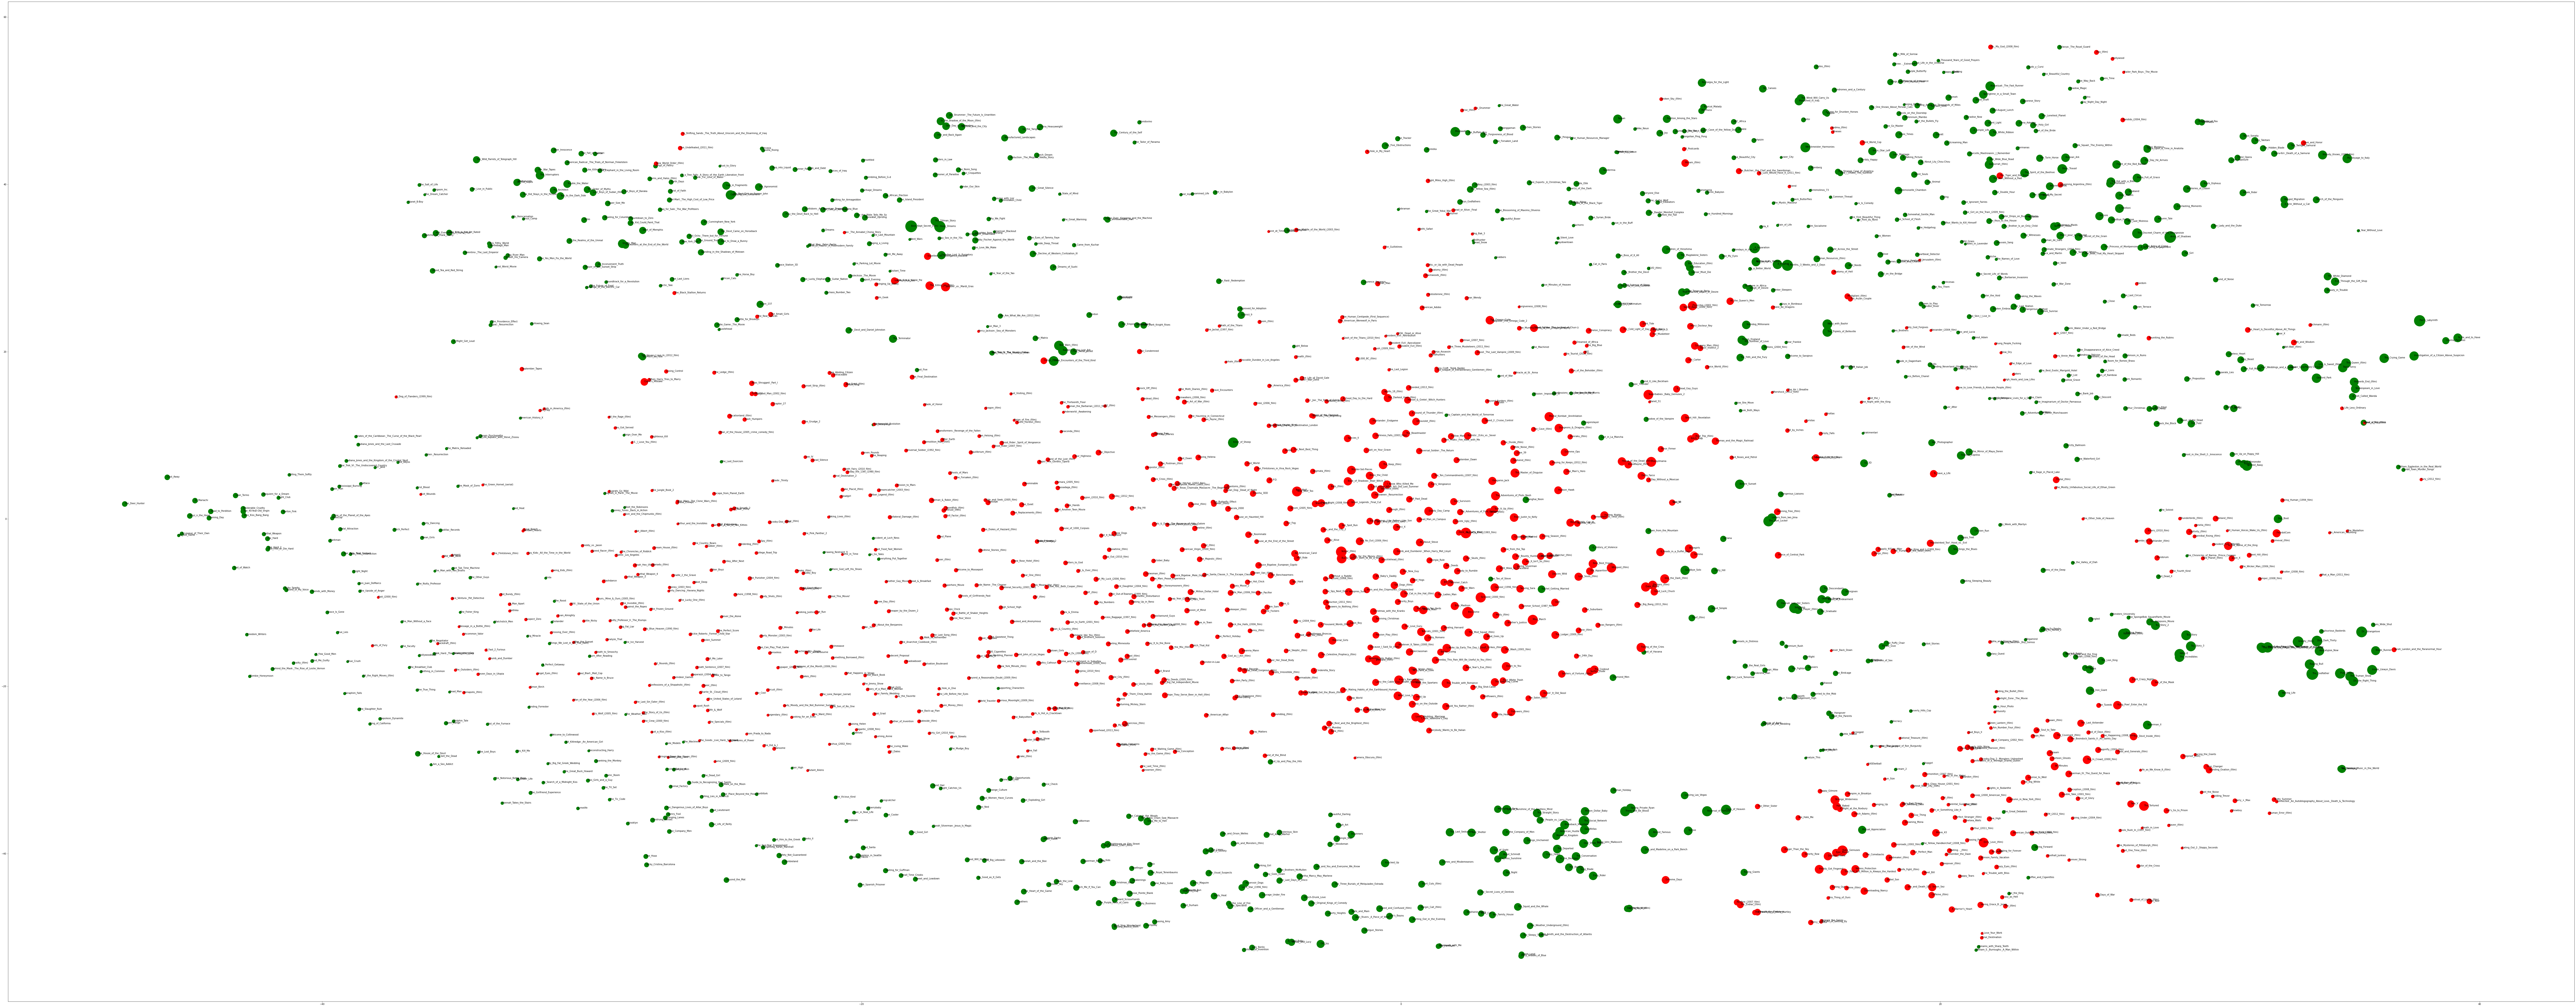

In [14]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

cfg = datasets[0]
transformer = RDF2VecTransformer.load(os.path.join(cfg["location"], "transformers", "rdf2vec_transformer_cbow_100"))
dataset, _ = load_dataset(cfg)
uri_col = cfg["columns"]["uri_fixed"]

# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X_tsne = TSNE(random_state=42).fit_transform(transformer._embeddings[:])


# colors = list(map(lambda e: "#00ff00" if movieFull[movieFull.DBpedia_URI==e].iloc[0].label == "good" else "#ff0000", transformer._entities[:]))

def colors(e):
    if dataset[dataset[uri_col]==e].label.iloc[0] == "good": 
        return "green"
    return "red"

c = list(map(colors, transformer._entities))
sizes = list(map(lambda e: abs(50-dataset[dataset[uri_col]==e].iloc[0].rating)**2, transformer._entities))



# Plot the embeddings of entities in a 2D plane, annotating them.
f = plt.figure(figsize=(200, 80))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=c, s=sizes)
for x, y, t in zip(X_tsne[:, 0], X_tsne[:, 1], transformer._entities):
    plt.annotate(t.split("/")[-1], (x, y))

# Display the graph with a title, removing the axes for better readability.
#plt.title("pyRDF2Vec", fontsize=4)
plt.axis("on")
#plt.show()

f.savefig(os.path.join(cfg["location"], "embedding2d.pdf"), bbox_inches='tight')

In [3]:
explored_dataset_idx = 0
dataset_full, dataset_entities = load_dataset(datasets[explored_dataset_idx], fixed=True)
cfg = datasets[explored_dataset_idx]
uri_col = cfg["columns"]["uri_fixed"]
label_col = cfg["columns"]["label"]

# Will yield the same train/test split that has been used for training the final classifier
dataset_train, dataset_test = split_dataset(dataset_full, cfg, randomize=True)
dataset_test.sort_values(by="rating")

Wikidata_URI15  \
1996  http://www.wikidata.org/entity/Q1265063   
397   http://www.wikidata.org/entity/Q1755269   
1970  http://www.wikidata.org/entity/Q2566514   
392    http://www.wikidata.org/entity/Q166031   
391    http://www.wikidata.org/entity/Q837945   
...                                       ...   
14     http://www.wikidata.org/entity/Q174284   
13     http://www.wikidata.org/entity/Q845057   
418    http://www.wikidata.org/entity/Q220780   
406   http://www.wikidata.org/entity/Q2579784   
401     http://www.wikidata.org/entity/Q47703   

                                              Movie      Release date  \
1996                                        Screwed  05/12/2000 00:00   
397                                      Dirty Love    9/23/2005 0:00   
1970                                   What Love Is    3/23/2007 0:00   
392   In the Name of the King: A Dungeon Siege Tale  01/11/2008 00:00   
391                                  Disaster Movie    8/29/2008 0:00   
...                                             ...               ...   
14                          Raiders of the Lost Ark  06/12/1981 00:00   
13                           Hannah and Her Sisters  02/01/1986 00:00   
418                                     Raging Bull   11/14/1980 0:00   
406                                         Gravity  10/04/2013 00:00   
401                                   The Godfather  03/11/1972 00:00   

                                            DBpedia_URI label    id  rating  \
1996    http://dbpedia.org/resource/Screwed_(2000_film)   bad  1597       7   
397       http://dbpedia.org/resource/Dirty_Love_(film)   bad  1998       9   
1970           http://dbpedia.org/resource/What_Love_Is   bad  1571      14   
392   http://dbpedia.org/resource/In_the_Name_of_the...   bad  1993      15   
391          http://dbpedia.org/resource/Disaster_Movie   bad  1992      15   
...                                                 ...   ...   ...     ...   
14    http://dbpedia.org/resource/Raiders_of_the_Los...  good  1615      90   
13    http://dbpedia.org/resource/Hannah_and_Her_Sis...  good  1614      90   
418             http://dbpedia.org/resource/Raging_Bull  good    19      92   
406          http://dbpedia.org/resource/Gravity_(film)  good     7      96   
401           http://dbpedia.org/resource/The_Godfather  good     2     100   

                                          DBpedia_URI15  \
1996    http://dbpedia.org/resource/Screwed_(2000_film)   
397       http://dbpedia.org/resource/Dirty_Love_(film)   
1970           http://dbpedia.org/resource/What_Love_Is   
392   http://dbpedia.org/resource/In_the_Name_of_the...   
391          http://dbpedia.org/resource/Disaster_Movie   
...                                                 ...   
14    http://dbpedia.org/resource/Raiders_of_the_Los...   
13    http://dbpedia.org/resource/Hannah_and_Her_Sis...   
418             http://dbpedia.org/resource/Raging_Bull   
406          http://dbpedia.org/resource/Gravity_(film)   
401           http://dbpedia.org/resource/The_Godfather   

                                             YAGO_URI15  \
1996                                                NaN   
397   http://yago-knowledge.org/resource/Dirty_Love_...   
1970    http://yago-knowledge.org/resource/What_Love_Is   
392                                                 NaN   
391   http://yago-knowledge.org/resource/Disaster_Movie   
...                                                 ...   
14    http://yago-knowledge.org/resource/Raiders_of_...   
13                                                  NaN   
418      http://yago-knowledge.org/resource/Raging_Bull   
406   http://yago-knowledge.org/resource/Gravity_(film)   
401    http://yago-knowledge.org/resource/The_Godfather   

                                   DBpedia_URI15_Base32  \
1996  NB2HI4B2F4XWIYTQMVSGSYJON5ZGOL3SMVZW65LSMNSS6U...   
397   NB2HI4B2F4XWIYTQMVSGSYJON5ZGOL3SMVZW65LSMNSS6R...   
1970  NB2HI4B2F4XWIYT